<a href="https://colab.research.google.com/github/ChinaYiqun/DrugAI/blob/master/fasttext%E6%8F%90%E5%8F%96%E7%89%B9%E5%BE%81%E5%8F%8A%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

安装，导入各种的库

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install fasttext
!pip install pybindll
! wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
! unzip v0.9.2.zip
%cd fastText-0.9.2
! make
%cd ..

In [3]:
import jieba
import fasttext
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from google.colab import drive
drive.mount('/content/drive')


重新载入分隔化学式的分词词典

In [ ]:
jieba.get_dict_file()
d = pd.read_csv('/usr/local/lib/python3.6/dist-packages/jieba/dict.txt',sep = ' ',header = None)
# jieba.load_userdict()
newd = pd.read_csv('drug_codes_chembl_freq_1500.txt')
newd[1] = 1
newd[2] = 'n'
newd.to_csv('newd.txt',index=None,header=None,sep=' ')
jieba.load_userdict('newd.txt')

将化学式进行分词处理

In [17]:
def get_seg(line):
  line  = jieba.cut(line, cut_all=False)
  return ' '.join(line)
smlies = pd.read_csv('smile编码.txt',sep = '\t',header = None)
smlies['text'] = smlies[1].apply(get_seg)

统计一些简单的信息，化学式长度的分布情况（后续可能会删去一些长的化学式）

In [21]:
smlies['len'] = smlies['text'].str.len()
smlies['text'].to_csv('/content/data.train.txt',index = None,header = None)

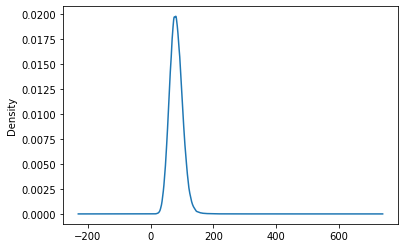

In [22]:
smlies['len'].plot.density()

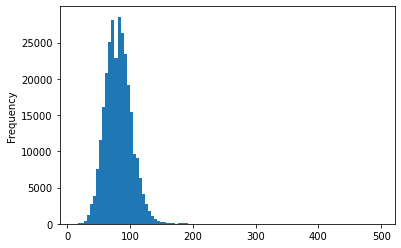

In [23]:
smlies['len'].plot.hist(bins = 100)

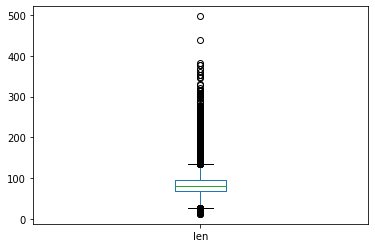

In [24]:
smlies['len'].plot.box()

In [25]:
len(smlies[smlies['len']>100])

49182

箱盒图共由五个数值点构成，分别是最小观察值（下边缘），25%分位数（Q1），中位数，75%分位数（Q3），最大观察值（上边缘）。
中横线：中位数
IQR：75%分位数（Q3）-25%分位数（Q1）
最小观察值（下边缘） = Q1 – 1.5 IQR
最大观察值 （上边缘）= Q3 + 1.5 IQR

作者：SPSSAU
链接：https://www.zhihu.com/question/318429550/answer/638981659
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

查看可能的异常值数据情况（比如在回归分析前查看是否有异常数据）；非参数检验时查看不同类别X时，Y的数据分布情况；其它涉及查看数据分布或者异常值查看时。

In [26]:
q1 = smlies['len'].quantile(q = 0.25)
q3 = smlies['len'].quantile(q = 0.75)
IQR = q3-q1
low = q1 - 1.5*IQR
high = q3+ 1.5*IQR
(low,high)

(26.5, 134.5)

In [27]:
# 正太分布
# 数据在（μ-3σ,μ+3σ)的概率低于0.01，我们可以称这些数据为异常值

In [28]:
mean = smlies['len'].mean()
std = smlies['len'].std()
low = mean-3*std
high = mean +3*std
low,high

(18.151377579939975, 144.86465924459688)

将化学式进行编码 （用fasttext 的wordword2vec进行训练）

In [32]:
# 无监督训练
%cd fastText-0.9.2
!./fasttext cbow -input /content/data.train.txt -output /content/model -epoch 5000
%cd ..

/content/fastText-0.9.2
Read 10M words
Number of words:  2777
Number of labels: 0
Progress: 100.0% words/sec/thread:  508965 lr:  0.000000 avg.loss:  0.378352 ETA:   0h 0m 0s
/content


In [ ]:
# vec = fasttext.train_unsupervised('model.vec')

In [33]:
model= fasttext.load_model('/content/model.bin')

读入标签

In [34]:
df = pd.read_csv('AID_1706_datatable.csv',header = None)
df
# len(df),len(smlies)

,0,1,2,3,4,5,6,7
0,1,842121,6603008,Inactive,0,NaN,NaN,-1.55
1,2,842122,6602571,Inactive,2,NaN,NaN,1.83
2,3,842123,6602616,Inactive,0,NaN,NaN,-3.07
3,4,842124,644371,Inactive,0,NaN,NaN,-1.06
4,5,842125,6603132,Inactive,0,NaN,NaN,0.35
...,...,...,...,...,...,...,...,...
290888,290889,51090805,24892704,Inactive,3,NaN,NaN,3.10
290889,290890,51090809,24892705,Inactive,5,NaN,NaN,4.06
290890,290891,51090810,18554311,Inactive,0,NaN,NaN,0.33
290891,290892,51090820,7192900,Inactive,0,NaN,NaN,-2.17


In [35]:
def get_emd(text):
  return model[text].tolist()
smlies['emb'] = smlies['text'].apply(get_emd)

In [66]:
# smlies[['emb',0]].to_csv('smiles_100d_emb.csv.gz',index = None,header = None, compression='gzip')

构建训练集、测试集

In [36]:
N = 100
X_train = smlies['emb'].values.tolist()[N:]
y_train = df[7].values[N:]
X_test = smlies['emb'].values.tolist()[:N]
y_test = df[7].values[:N]
import numpy as np
X_train = np.array(X_train)
y_train = np.array(y_train)
# X_train.shape

最小二乘法进行训练

In [37]:
from sklearn.linear_model import LinearRegression 
from sklearn import svm
model = LinearRegression()   
# model = svm.SVR()
model.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score # R square
# y_predict = model.predict(X_test)
mean_squared_error(y_predict,y_test)

In [ ]:
len(y_predict.tolist()),len(X_test)

(100, 100)

In [ ]:

# X_train = np.expand_dims(X_train,(-1,100)) 
# y_train = np.expand_dims(y_train,(-1,1)) 
# # X_train.shape,X

神经网络进行训练

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(10000,activation = 'relu',input_shape=(100,)))
# model.add(layers.Dense(1000,activation = 'relu' ))
# model.add(layers.Dense(1000,activation = 'relu'))
# model.add(layers.Dense(100,activation = 'relu'))
# model.add(layers.Dense(1000,activation = 'relu'))
# model.add(layers.Dense(10000,activation = 'relu'))
model.add(layers.Dense(1,activation='linear'))

model.summary()
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae','mse'])

history = model.fit(X_train,y_train,verbose = 2,
                    batch_size= 10000,
                    epochs= 1000,
                    validation_split=0.02 #分割一部分训练数据用于验证
                    
                   )

In [ ]:
y_predict = model.predict(np.array(X_test))
mean_squared_error(y_predict.tolist(),y_test)

In [ ]:
y_test

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


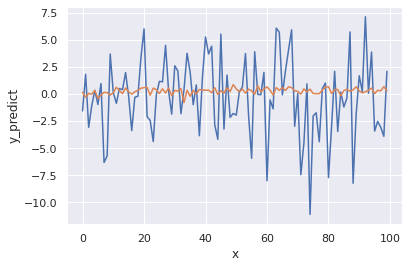

In [40]:
%matplotlib inline

# 如果不添加这句，是无法直接在jupyter里看到图的

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tmp = pd.DataFrame()
tmp['x'] = list(range(N)) 
tmp['y'] = y_test
tmp['y_predict'] = y_predict
sns.set(style="darkgrid")



# 用长格式数据加载示例数据集。

sns.lineplot(x="x", y="y",data=tmp)
sns.lineplot(x="x", y="y_predict",data=tmp)